# Lab 04: Naive Bayes

Trong bài tập này, chúng ta sẽ xây dựng một mô hình dự đoán đội chiến thắng trong một trận đấu Liên Minh Huyền Thoại.

Về cơ bản, Liên Minh Huyền Thoại là một game giữa hai đội Blue và Red với mục tiêu là phá hủy nhà chính đối phương. Mỗi đội có 5 người chơi, mỗi người điều khiển 1 nhân vật. Trong trò chơi, để chiến thắng người chơi có thể:
- Hạ gục đối phương: thể hiện bằng chỉ số hạ gục (Kills)
- Hạ gục lính kiếm tiền mua trang bị (MinionsKilled)
- Cắm mắt để có tầm nhìn, thêm thông tin về đối phương (WardsPlaced)
- Ăn sứ giả lấy bùa và vật phẩm (Heralds)
- Ăn bùa rồng (Dragons)

## Data

Dựa vào các thông tin trong 10 phút đầu của trận đấu
- killsDiff: số mạng hạ gục chênh lêch giữa đội Blue và Red, số nguyên
- minionsKilledDiff: số lính hạ gục chênh lêch giữa đội Blue và Red, số nguyên
- wardPlacedDiff: số mắt đã cắm chênh lêch giữa đội Blue và Red, số nguyên
- firstBlood: đội nào có mạng hạ gục đầu tiên, category: blue hoặc red
- heralds: đội nào hạ gục heralds, category: none, blue hoặc red
- dragons: đội nào hạ gục dragons, category: none, blue hoặc red

Hãy dự đoán đội nào chiến thắng: blue hay red

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/lienminh.csv')
df.head()

,killsDiff,minionsKilledDiff,wardPlacedDiff,firstBlood,heralds,dragons,teamWins
0,3,-2,13,blue,none,none,red
1,0,-66,0,red,red,red,red
2,-4,-17,0,red,none,blue,red
3,-1,-34,28,red,blue,none,red
4,0,-15,58,red,none,red,red


In [ ]:
killsDiff = df['killsDiff'].values
minionsKilledDiff = df['minionsKilledDiff'].values
wardPlacedDiff = df['wardPlacedDiff'].values
firstBlood = df['firstBlood'].values
heralds = df['heralds'].values
dragons = df['dragons'].values
teamWins = df['teamWins'].values

### Analyse

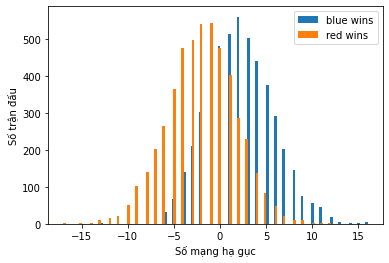

In [ ]:
## vẽ histogram (phân phối) của chênh lệch mạng hạ gục khi từng đội thắng
_ = plt.hist(killsDiff[teamWins=='blue'], bins=100, label='blue wins')
_ = plt.hist(killsDiff[teamWins=='red'], bins=100, label='red wins')
plt.xlabel("Số mạng hạ gục")
plt.ylabel("Số trận đấu")
plt.legend()

In [ ]:
# tính tương quan tuyến tính (correlation coefficient) giữa  việc hạ gục mạng đầu và chiến thắng
np.corrcoef((firstBlood == 'blue').astype(int), (teamWins == 'blue').astype(int))

array([[1.        , 0.20176926],
       [0.20176926, 1.        ]])

## Categorical Naive Bayes

Gọi $X$ là một biến thể hiện đội nào có mạng hạ gục đầu tiên, $X$ có không gian mẫu hữu hạn $\Omega = \{blue, red\}$. Ta muốn đoán xem đội nào thắng dựa vào $X$ bằng cách tính $P(B|X)$ và $P(R|X)$, với $B$ và $R$ lần lượt là biến cố blue và red thắng. Ta giả thuyết
$$ P(B|X) = \frac{P(X|B)P(B)}{P(X|B)P(B) + P(X|R)P(R)}, P(R|X) = 1 - P(B|X).$$
$P(B)$ và $P(R)$ là xác suất tiên nghiệm, ta xem như hai tỉ lệ hai đội thắng bằng nhau. 

Giờ chỉ cần tính $P(X|B)$ và $P(X|R)$.

In [ ]:
## xác suất tiên nghiệm
P_blueWins = 0.5
P_redWins = 0.5

In [ ]:
is_bluefirstBlood = (firstBlood == 'blue').astype(float)

## tính P(X|B)
P_blueFirstBlood_blueWins  = np.sum(firstBlood[teamWins == 'blue'] == 'blue') / np.sum(teamWins == 'blue')
P_blueFirstBlood_blueWins = P_blueFirstBlood_blueWins * is_bluefirstBlood + (1-P_blueFirstBlood_blueWins)*(1-is_bluefirstBlood)
P_redFirstBlood_blueWins = 1 - P_blueFirstBlood_blueWins

## tính P(X|R)
P_blueFirstBlood_redWins = np.sum(firstBlood[teamWins == 'red'] == 'blue') / np.sum(teamWins == 'red')
P_blueFirstBlood_redWins = P_blueFirstBlood_redWins * is_bluefirstBlood + (1-P_blueFirstBlood_redWins)*(1-is_bluefirstBlood)

In [ ]:
## P(B|X)
P_blueWins_blueFirstBlood = P_blueFirstBlood_blueWins * P_blueWins / (P_blueFirstBlood_blueWins * P_blueWins + P_blueFirstBlood_redWins * P_redWins)
acc = np.mean((P_blueWins_blueFirstBlood > 0.5) == (teamWins == 'blue'))
print(acc)

0.6008705334548031


In [ ]:
## Dùng sklearn
from sklearn.naive_bayes import CategoricalNB
blueFirstBlood_float = (firstBlood.reshape(-1,1) == 'blue').astype(float)
nb = CategoricalNB(alpha=1.0e-10).fit(blueFirstBlood_float, teamWins)
np.mean(teamWins == nb.predict(blueFirstBlood_float))

0.6008705334548031

## Gaussian Naive Bayes

Gọi $X$ là biến thể hiện chênh lệnh mạng hạ gục. Ta muốn đoán xem đội nào thắng dựa vào $X$ bằng cách tính $P(B|X)$ và $P(R|X)$. 
$$ P(B|X) = \frac{P(X|B)P(B)}{P(X|B)P(B) + P(X|R)P(R)}, P(R|X) = 1 - P(B|X).$$
Ta xấp xỉ $P(X|B)$ có phân phối Gauss: 
$$P(X=x|B) = \frac{1}{\sqrt{2\pi}  \sigma} e^{-\frac{(x- \mu)^2}{2  \sigma^2}}$$
với $ \mu$ và $ \sigma$ là trung bình và độ lệch chuẩn của mạng chênh lệch khi Blue thắng
$$( \mu, \sigma) = \left( \frac{1}{n}\sum_{i, \text{blue wins}}{x_i}, \sqrt{\frac{1}{n} \sum_{i, \text{blue wins}} (x_i -  \mu) ^2}\right)$$

$P(X|R)$ xấp xỉ tương tự.

In [ ]:
## xác suất tiên nghiệm
P_blueWins = 0.5
P_redWins = 0.5

## tính tham số
killsDiff_mean_blueWins = np.mean(killsDiff[teamWins == 'blue'])
killsDiff_std_blueWins = np.std(killsDiff[teamWins == 'blue'])

killsDiff_mean_redWins = np.mean(killsDiff[teamWins == 'red'])
killsDiff_std_redWins = np.std(killsDiff[teamWins == 'red'])

def normal(x, mean, std):
    return 1/(np.sqrt(2*np.pi)*std)*np.exp(-np.square(x-mean)/(2*np.square(std)))

## P(X|B) và P(X|R)
P_killsDiff_blueWins = normal(killsDiff, killsDiff_mean_blueWins, killsDiff_std_blueWins)
P_killsDiff_redWins = normal(killsDiff, killsDiff_mean_redWins, killsDiff_std_redWins)

In [ ]:
## P(B|X)
P_blueWins_killsDiff = P_killsDiff_blueWins * P_blueWins / (P_killsDiff_blueWins * P_blueWins + P_killsDiff_redWins * P_redWins)
## accuracy
acc = np.mean((P_blueWins_killsDiff > 0.5) == (teamWins == 'blue'))
acc

0.7042210750075919

In [ ]:
## Dùng sklearn
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(killsDiff.reshape(-1,1), teamWins)
np.mean(teamWins == nb.predict(killsDiff.reshape(-1,1)))

0.7042210750075919

In [ ]:
## xác suất tiên nghiệm
P_blueWins = 0.5
P_redWins = 0.5

## tính tham số
minionsKilledDiff_mean_blueWins = np.mean(minionsKilledDiff[teamWins == 'blue'])
minionsKilledDiff_std_blueWins = np.std(minionsKilledDiff[teamWins == 'blue'])

minionsKilledDiff_mean_redWins = np.mean(minionsKilledDiff[teamWins == 'red'])
minionsKilledDiff_std_redWins = np.std(minionsKilledDiff[teamWins == 'red'])

def normal(x, mean, std):
    return 1/(np.sqrt(2*np.pi)*std)*np.exp(-np.square(x-mean)/(2*np.square(std)))

## P(X|B) và P(X|R)
P_minionsKilledDiff_blueWins = normal(minionsKilledDiff, minionsKilledDiff_mean_blueWins, minionsKilledDiff_std_blueWins)
P_minionsKilledDiff_redWins = normal(minionsKilledDiff, minionsKilledDiff_mean_redWins, minionsKilledDiff_std_redWins)

In [ ]:
## P(B|X)
P_blueWins_minionsKilledDiff = P_minionsKilledDiff_blueWins * P_blueWins / (P_minionsKilledDiff_blueWins * P_blueWins + P_minionsKilledDiff_redWins * P_redWins)
## accuracy
acc = np.mean((P_blueWins_minionsKilledDiff > 0.5) == (teamWins == 'blue'))
acc

0.6263791881769409

In [ ]:
## Dùng sklearn
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(minionsKilledDiff.reshape(-1,1), teamWins)
np.mean(teamWins == nb.predict(minionsKilledDiff.reshape(-1,1)))

0.6263791881769409

## Bài tập

Hãy xây dựng mô hình Naive Bayes sử dụng tất các cả thông tin mà dữ liệu cho:
- killsDiff, minionsKilledDiff, wardPlacedDiff: xấp xỉ bằng phân mối normal
- firstBlood, heralds, dragons: xấp xỉ bằng phân phối category

Note: kết quả không nhất thiết tốt hơn, quan trọng phải đúng

In [ ]:
## xác suất tiên nghiệm
pBlueWins = 0.5
pRedWins = 0.5

#Dragons

In [ ]:
print(df['dragons'].unique())

['none' 'red' 'blue']


In [ ]:
isBlueDragons = (dragons == 'blue').astype(float)
isRedDragons = (dragons == 'red').astype(float)
isNoneDragons = (dragons == 'none').astype(float) 

In [ ]:
## tính P(X|B)
### Xác suất Blue ăn Dragon và Bule Win
pBlueDragonsBlueWins  = np.sum(dragons[teamWins == 'blue'] == 'blue') / np.sum(teamWins == 'blue')
### Xác suất red ăn Dragon và Bule Win
pRedDragonsBlueWins  = np.sum(dragons[teamWins == 'blue'] == 'red') / np.sum(teamWins == 'blue')
### Xác suất không team ăn Dragon và Bule Win
pNoneDragonsBlueWins  = np.sum(dragons[teamWins == 'blue'] == 'none') / np.sum(teamWins == 'blue')
### Xác suất Dragon và Bule Win
pDragonsBlueWins = pBlueDragonsBlueWins * isBlueDragons + \
                     pRedDragonsBlueWins * isRedDragons + \
                     pNoneDragonsBlueWins * isNoneDragons
np.mean(pDragonsBlueWins)

0.34692643049868926

In [ ]:
## tính P(X|B) 
### Xác suất Blue ăn Dragon và red Win
pBlueDragonsRedWins  = np.sum(dragons[teamWins == 'red'] == 'blue') / np.sum(teamWins == 'red')
### Xác suất red ăn Dragon và red Win
pRedDragonsRedWins  = np.sum(dragons[teamWins == 'red'] == 'red') / np.sum(teamWins == 'red')
### Xác suất không team ăn Dragon và red Win
pNoneDragonsRedWins  = np.sum(dragons[teamWins == 'red'] == 'none') / np.sum(teamWins == 'red')
### Xác suất Dragon và red Win
pDragonsRedWins = pBlueDragonsRedWins * isBlueDragons + \
                     pRedDragonsRedWins * isRedDragons + \
                     pNoneDragonsRedWins * isNoneDragons
np.mean(pDragonsRedWins)

0.35759217139634475

In [ ]:
## tính P(X)
pDragons = pDragonsBlueWins * pBlueWins + pDragonsRedWins * pRedWins
np.mean(pDragons)

0.352259300947517

# firstBlood

In [ ]:
print(df['firstBlood'].unique())

['blue' 'red']


In [ ]:
isBlueFirstBlood = (firstBlood == 'blue').astype(float)

In [ ]:
## tính P(X|B)
### Xác suất Blue kill first và Blue Win
pBlueFirstBloodBlueWins  = np.sum(firstBlood[teamWins == 'blue'] == 'blue') / np.sum(teamWins == 'blue')
pFirstBloodBlueWins = pBlueFirstBloodBlueWins * isBlueFirstBlood + (1-pBlueFirstBloodBlueWins)*(1-isBlueFirstBlood)

## tính P(X|R)
### Xác suất Blue kill first và Red Win
pBlueFirstBloodRedWins = np.sum(firstBlood[teamWins == 'red'] == 'blue') / np.sum(teamWins == 'red')
pFirstBloodRedWins = pBlueFirstBloodRedWins * isBlueFirstBlood + (1-pBlueFirstBloodRedWins)*(1-isBlueFirstBlood)

## tính P(X)
pFirstBlood = pFirstBloodBlueWins * pBlueWins + pFirstBloodRedWins * pRedWins
np.mean(pFirstBlood)

0.5000481029350581

# heralds

In [ ]:
print(df['heralds'].unique())

['none' 'red' 'blue']


In [ ]:
isBlueHeralds = (heralds == 'blue').astype(float)
isRedHeralds = (heralds == 'red').astype(float)
isNoneHeralds = (heralds == 'none').astype(float) 

In [ ]:
## tính P(X|B)
### Xác suất Blue ăn Heralds và Bule Win
pBlueHeraldsBlueWins  = np.sum(heralds[teamWins == 'blue'] == 'blue') / np.sum(teamWins == 'blue')
### Xác suất red ăn Dragon và Bule Win
pRedHeraldsBlueWins  = np.sum(heralds[teamWins == 'blue'] == 'red') / np.sum(teamWins == 'blue')
### Xác suất không team ăn Heralds và Bule Win
pNoneHeraldsBlueWins  = np.sum(heralds[teamWins == 'blue'] == 'none') / np.sum(teamWins == 'blue')
### Xác suất Heralds và Bule Win
pHeraldsBlueWins = pBlueHeraldsBlueWins * isBlueHeralds + \
                     pRedHeraldsBlueWins * isRedHeralds + \
                     pNoneHeraldsBlueWins * isNoneHeralds
np.mean(pHeraldsBlueWins)

0.4868160317940385

In [ ]:
## tính P(X|B) 
### Xác suất Blue ăn Heralds và red Win
pBlueHeraldsRedWins  = np.sum(heralds[teamWins == 'red'] == 'blue') / np.sum(teamWins == 'red')
### Xác suất red ăn Heralds và red Win
pRedHeraldsRedWins  = np.sum(heralds[teamWins == 'red'] == 'red') / np.sum(teamWins == 'red')
### Xác suất không team ăn Heralds và red Win
pNoneHeraldsRedWins  = np.sum(heralds[teamWins == 'red'] == 'none') / np.sum(teamWins == 'red')
### Xác suất Heralds và red Win
pHeraldsRedWins = pBlueHeraldsRedWins * isBlueHeralds + \
                     pRedHeraldsRedWins * isRedHeralds + \
                     pNoneHeraldsRedWins * isNoneHeralds
np.mean(pHeraldsRedWins)

0.48525859607657995

In [ ]:
## tính P(X)
pHeralds = pHeraldsBlueWins * pBlueWins + pHeraldsRedWins * pRedWins
np.mean(pHeralds)

0.4860373139353093

# killsDiff

In [ ]:
def normal(x, mean, std):
    return 1/(np.sqrt(2*np.pi)*std)*np.exp(-np.square(x-mean)/(2*np.square(std)))

In [ ]:
## tính tham số
### Trung bình Kill Diferent Blue Win
killsDiffMeanBlueWins = np.mean(killsDiff[teamWins == 'blue'])
### Độ lệch chuẩn Kill Diferent Blue Win
killsDiffStdBlueWins = np.std(killsDiff[teamWins == 'blue'])
### Trung bình Kill Diferent Red Win
killsDiffMeanRedWins = np.mean(killsDiff[teamWins == 'red'])
### Độ lệch chuẩn Kill Diferent Red Win
killsDiffStdRedWins = np.std(killsDiff[teamWins == 'red'])

## P(X|B) và P(X|R)
### Xác suất Kill Diferent và blue Win
pKillsDiffBlueWins = normal(killsDiff, killsDiffMeanBlueWins, killsDiffStdBlueWins)
### Xác suất Kill Diferent và red Win
pKillsDiffRedWins = normal(killsDiff, killsDiffMeanRedWins, killsDiffStdRedWins)

## tính P(X)
pKillsDiff = pKillsDiffBlueWins * pBlueWins + pKillsDiffRedWins * pRedWins
np.mean(pKillsDiff)

0.06723327832253297

# minionsKilledDiff

In [ ]:
## tính tham số
### Trung bình Minions Killed Different Blue Win
minionsKilledDiffMeanBlueWins = np.mean(minionsKilledDiff[teamWins == 'blue'])
### Độ lệch chuẩn Minions Killed Different Blue Win
minionsKilledDiffStdBlueWins = np.std(minionsKilledDiff[teamWins == 'blue'])
### Trung bình Minions Killed Different Red Win
minionsKilledDiffMeanRedWins = np.mean(minionsKilledDiff[teamWins == 'red'])
### Độ lệch chuẩn Minions Killed Different Red Win
minionsKilledDiffStdRedWins = np.std(minionsKilledDiff[teamWins == 'red'])

## P(X|B) và P(X|R)
### Xác suất Minions Killed Different và blue Win
pMinionsKilledDiffBlueWins = normal(minionsKilledDiff, minionsKilledDiffMeanBlueWins, minionsKilledDiffStdBlueWins)
### Xác suất Minions Killed Different và red Win
pMinionsKilledDiffRedWins = normal(minionsKilledDiff, minionsKilledDiffMeanRedWins, minionsKilledDiffStdRedWins)

## tính P(X)
pMinionsKilledDiff = pMinionsKilledDiffBlueWins * pBlueWins + pMinionsKilledDiffRedWins * pRedWins
np.mean(pMinionsKilledDiff)

0.009174215457689577

#Ward Placed Different

In [ ]:
## tính tham số
### Trung bình Ward Placed Different Blue Win
wardPlacedDiffMeanBlueWins = np.mean(wardPlacedDiff[teamWins == 'blue'])
### Độ lệch chuẩn Ward Placed Different Blue Win
wardPlacedDiffStdBlueWins = np.std(wardPlacedDiff[teamWins == 'blue'])
### Trung bình Ward Placed Different Red Win
wardPlacedDiffMeanRedWins = np.mean(wardPlacedDiff[teamWins == 'red'])
### Độ lệch chuẩn Ward Placed Different Red Win
wardPlacedDiffStdRedWins = np.std(wardPlacedDiff[teamWins == 'red'])

## P(X|B) và P(X|R)
### Xác suất Ward Placed Different và blue Win
pWardPlacedDiffBlueWins = normal(wardPlacedDiff, wardPlacedDiffMeanBlueWins, wardPlacedDiffStdBlueWins)
### Xác suất Ward Placed Different và red Win
pWardPlacedDiffRedWins = normal(wardPlacedDiff, wardPlacedDiffMeanRedWins, wardPlacedDiffStdRedWins)

## tính P(X)
pWardPlacedDiff = pWardPlacedDiffBlueWins * pBlueWins + pWardPlacedDiffRedWins * pRedWins
np.mean(pWardPlacedDiff)

0.012878877148017404

In [ ]:
## P(B|X)
pBlueWinsX = (pFirstBloodBlueWins * pHeraldsBlueWins * pDragonsBlueWins * pKillsDiffBlueWins * pMinionsKilledDiffBlueWins * pWardPlacedDiffBlueWins * pBlueWins ) / \
               (pFirstBlood * pHeralds * pDragons* pKillsDiff * pMinionsKilledDiff * pWardPlacedDiff)
acc = np.mean((pBlueWinsX > 0.5) == (teamWins == 'blue'))
print(acc)

0.7115092620710598


In [91]:
## Dùng sklearn
from sklearn.naive_bayes import CategoricalNB
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler #fixed import

killsDiff = df['killsDiff'].values
minionsKilledDiff = df['minionsKilledDiff'].values
wardPlacedDiff = df['wardPlacedDiff'].values
firstBlood = df['firstBlood'].values
heralds = df['heralds'].values
dragons = df['dragons'].values
teamWins = df['teamWins'].values

killsDiff_scale = MinMaxScaler(feature_range=(0,max(killsDiff)+abs(min(killsDiff)))).fit_transform(killsDiff.reshape(-1,1)).reshape(1,-1)[0]
minionsKilledDiff_scale = MinMaxScaler(feature_range=(0,max(minionsKilledDiff)+abs(min(minionsKilledDiff)))).fit_transform(minionsKilledDiff.reshape(-1,1)).reshape(1,-1)[0]
wardPlacedDiff_scale = MinMaxScaler(feature_range=(0,max(wardPlacedDiff)+abs(min(wardPlacedDiff)))).fit_transform(wardPlacedDiff.reshape(-1,1)).reshape(1,-1)[0]
heralds_encoder = preprocessing.LabelEncoder().fit_transform(heralds)
dragons_encoder = preprocessing.LabelEncoder().fit_transform(dragons)
firstBlood_encoder = preprocessing.LabelEncoder().fit_transform(firstBlood)
teamWins_encoder = preprocessing.LabelEncoder().fit_transform(teamWins)

x_lienminh = list(zip(heralds_encoder,dragons_encoder,firstBlood_encoder,killsDiff_scale,minionsKilledDiff_scale,wardPlacedDiff_scale))
y_lienminh = teamWins_encoder
nb = CategoricalNB(alpha=1.0e-10).fit(x_lienminh,y_lienminh)
np.mean(y_lienminh == nb.predict(x_lienminh))

0.725680736916692